In [1]:
import matplotlib
import matplotlib.pyplot as plt

import librosa, librosa.display
import soundfile as sf

import numpy as np
import pandas as pd

import IPython.display as ipd

import os
import shutil
import pickle 



need to change directory: cd BallroomData/

### Put all the songs in a folder

In BallroomData, creates a folder all_songs with all the songs

In [5]:
folders = [_+'/' for _ in os.listdir() if _ != '.DS_Store' and _!='allBallroomFiles' and _!='nada']
try:
    os.makedirs('all_songs')
    
    for folder in folders:
        all_files_in_folder = os.listdir(folder)
        for file in all_files_in_folder:
            #print(folder + file)
            shutil.copy(folder + file, 'all_songs/')
except:
    print('Folder all_songs with all the songs already created')
        

Folder all_songs with all the songs already created


# Target variable

Get the target variable from the folder BallroomAnnotations-master

In [6]:
# Get the names of the songs in the folder
names_songs_in_annotations = set(os.listdir('BallroomAnnotations-master/'))
names_songs_in_annotations.remove('README.md')
names_songs = []
for _ in names_songs_in_annotations:
    names_songs.append(_[:-6])
    

#### Creates four dictionaries:
temps: (name of the song) --> times in seconds which have a beat

frames: (name of the song) --> frames which have a beat

time_first_beat: (name of the song) --> times in seconds which has the first beat. Sampling rate is 22050

frame_first_beat: (name of the song) --> frame which has the first beat. Sampling rate is 22050

In [7]:
## Creates three dictionaries:
#temps: (name of the song) --> times in seconds which have a beat
#frames: (name of the song) --> frames which have a beat
#time_first_beat: (name of the song) --> times in seconds which has the first beat. Sampling rate is 22050
#frame_first_beat: (name of the song) --> frame which has the first beat. Sampling rate is 22050

SAMPLING_RATE = 22016 #divisible by 512, so that the conversion to mel spectrogram is more even

temps = {}
frames = {}
time_first_beat = {}
frame_first_beat = {}


for name in names_songs:
    file = open('BallroomAnnotations-master/' + name + '.beats')
    beats_in_seconds = file.read()
    temps[name] = []    
    first_beat_recorded = False
    for time in beats_in_seconds.split('\n'):        
        if len(time) > 0:
            temps[name].append(float(time[:-2]))
            if not first_beat_recorded:
                time_first_beat[name] = float(time[:-2])
                first_beat_recorded = True
    frames[name] = librosa.time_to_samples(temps[name], sr=SAMPLING_RATE)
    frame_first_beat[name] = frames[name][0]
    

## Inspect the first beats

Inspect the data to see when the first beat happens

In [8]:
first_beats = pd.DataFrame([list(time_first_beat.values()), list(frame_first_beat.values())],
                           columns=time_first_beat.keys(), index=['time','frame']).transpose()
first_beats.describe()

,time,frame
count,698.000000,698.000000
mean,0.752263,16561.322350
std,1.747817,38479.948877
min,0.000000,0.000000
25%,0.060000,1320.000000
50%,0.249082,5483.500000
75%,0.656650,14456.250000
max,21.070000,463877.000000


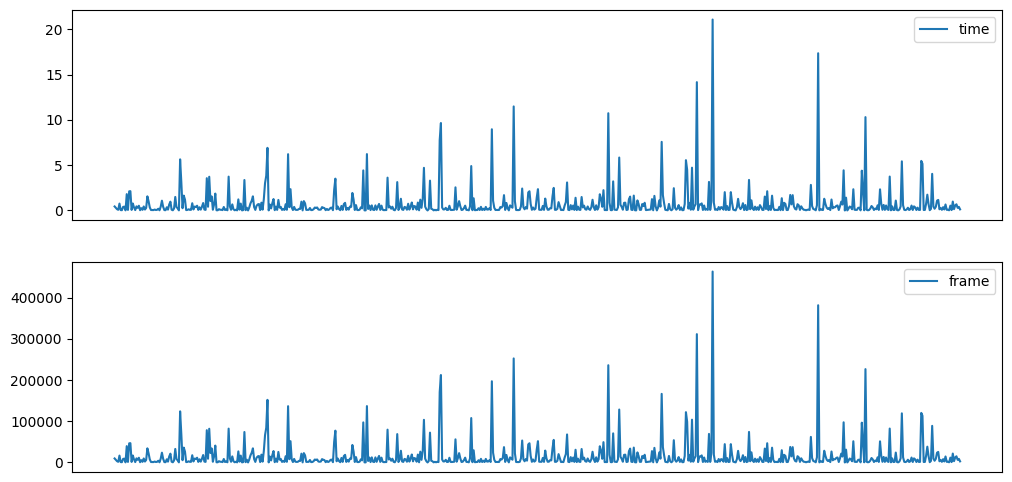

In [9]:
fig, axes = plt.subplots(nrows=2)

first_beats[['time']].plot(ax=axes[0], figsize=(12,6))
axes[0].set_xticks([])

first_beats[['frame']].plot(ax=axes[1], figsize=(12,6))
axes[1].set_xticks([])

plt.show()

As expected, the two plots look similar: the frame when the first beat happens, and the time when the first beat happens.

## Begin each song from the first beat

Makes the folder all_songs_from_first_beat, where all the songs in all_songs are trimmed so that they begin from the first beat

In [10]:
try:
    os.makedirs('all_songs_from_first_beat')
    
    for song in os.listdir('all_songs/'):
        if song[-3:] =='wav':
            _, sr__ = librosa.load('all_songs/' + song, sr=SAMPLING_RATE)
            
            sf.write('all_songs_from_first_beat/'+ song, _[frame_first_beat[song[:-4]]:], sr__)
        else:
            print('!! There was a file not ending in .wav !!')
            print('This was the file: '+song)

except:
    print('already created the directory all_songs_from_first_beat')


## Edit target beats to reflect that each songs in all_songs_from_first_beat begin with the firts beat

In [11]:
frames_starting_from_first_beat = {}

for song in frames.keys():
    frames_starting_from_first_beat[song] = [_ - frame_first_beat[song] for _ in frames[song]]
    

# Get length of each song

In [12]:
duration_songs = {}
for song in os.listdir('all_songs_from_first_beat/'):
    audio, _ = librosa.load('all_songs_from_first_beat/' + song,
                         sr=SAMPLING_RATE)
    duration_songs[song[:-4]] = librosa.get_duration(y=audio, sr=SAMPLING_RATE)

lengths_df = pd.DataFrame(duration_songs.values(), index=duration_songs.keys())
print(lengths_df.describe())

first_beats['length_song'] = lengths_df
first_beats.sort_index(inplace=True)
lengths_df.sort_index(inplace=True)
lengths_df[first_beats['length_song'] != lengths_df[0]]

                0
count  698.000000
mean    30.527934
std      1.863898
min     10.717978
25%     29.980026
50%     31.192996
75%     31.707985
max     33.712300


,0


## Trim songs to up to 29 seconds

From the previous cell, most of the songs last at least 29 seconds. So to have an uniforma dataset, we trim the songs to last at most 29 seconds, and we add them to a folder named all_songs_up_to_29_secs.

In [13]:
try:
    os.makedirs('all_songs_up_to_29_secs')
    
    for song in os.listdir('all_songs_from_first_beat/'):
        if song[-3:] =='wav':
            _, sr__ = librosa.load('all_songs_from_first_beat/' + song, sr=SAMPLING_RATE)
            
            sf.write('all_songs_up_to_29_secs/'+ song, _[:SAMPLING_RATE*29], SAMPLING_RATE)
        else:
            print('!! There was a file not ending in .wav !!')
            print('This was the file: '+song)

except:
    print('already created the directory all_songs_up_to_29_secs')

## Edit target beats to reflect that each songs in all_songs_up_to_29_secs end at 29 secs

In [14]:
frames_ending_at_29_secs = {}

for song in frames_starting_from_first_beat.keys():
    f = np.array(frames_starting_from_first_beat[song])
    frames_ending_at_29_secs[song] = f[f<SAMPLING_RATE*29].copy()
    

# X variable: get mel spectrograms

Get the mel spectrogram for each song

In [15]:
MEL_SAMPLING_RATE = int(SAMPLING_RATE/512) #=43

all_mels = {}

for name_song in os.listdir('all_songs_up_to_29_secs/'):
    audio, _ = librosa.load('all_songs_up_to_29_secs/' + name_song,
                            sr=SAMPLING_RATE)
    S_original_audio = librosa.feature.melspectrogram(y=audio, sr=SAMPLING_RATE, n_mels=128)
    db_spectrogram = librosa.power_to_db(S_original_audio, ref=np.max)
    first_derivative = librosa.feature.delta(db_spectrogram)
    
    all_mels[name_song[:-4]] = np.concatenate((db_spectrogram, first_derivative))
    

In [16]:
#with open('mels.pkl', 'wb') as f:
    #pickle.dump(all_mels, f)
    
#with open('mels.pkl', 'rb') as f:
    #loaded_dict = pickle.load(f)

## Convert frames with beat to reflect the shape of mel spectrogram

The frequency of the mel spectrogram is different than the sampling rate, so below we detect which frame in the mel spectrogram has a beat

In [17]:
frames_with_beat = {}

for song in frames_ending_at_29_secs.keys():
    times = librosa.frames_to_time(frames_ending_at_29_secs[song], sr=SAMPLING_RATE)
    new_frames = librosa.time_to_frames(times, sr=MEL_SAMPLING_RATE)
    frames_with_beat[song] = new_frames
    

### OH encode the beats which have a frame

In [18]:
frames_with_beat_encoded = {}

for song in frames_ending_at_29_secs.keys():
    zeros = np.zeros(all_mels[song].shape[1])
    for beat in frames_with_beat[song]:
        zeros[beat] = 1
    frames_with_beat_encoded[song] = zeros
    
    

Run the following cell for a safety check

In [ ]:
for song in frames_ending_at_29_secs.keys():
    if frames_with_beat_encoded[song].sum() != len(frames_with_beat[song]):
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(song)
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    else:
        print(song +' is okay')

# Create train and test dataset

In [20]:
num_test_songs = first_beats.shape[0]//4
num_short_songs = first_beats[first_beats['length_song']<=29].shape[0]
num_remaining_songs = num_test_songs - num_short_songs

num_remaining_songs

109

In [21]:
#long_test_songs = np.random.choice(np.array(first_beats[first_beats['length_song']>29].index), num_remaining_songs, False)


In [22]:
test_songs = list(long_test_songs) + list(first_beats[first_beats['length_song']<=29].index)
test_songs = list(set(test_songs))
print(len(test_songs))

174


In [23]:
train_songs = list(set(first_beats.index).difference(set(test_songs)))

In [24]:
try:
    os.makedirs('songs_train')
    os.makedirs('songs_test')

    for song in train_songs:
        song = song+'.wav'
        shutil.copyfile('all_songs_up_to_29_secs/'+song, 'songs_train/' + song)
    
    for song in test_songs:
        song = song+'.wav'
        shutil.copyfile('all_songs_up_to_29_secs/'+song, 'songs_test/' + song)
except:
    print('already created songs_train and/or songs_test')
    

### Safety check

In [25]:
for song in os.listdir('songs_train/'):
    audio, _ = librosa.load('songs_train/' + song,
                         sr=SAMPLING_RATE)
    if 29 != librosa.get_duration(y=audio, sr=SAMPLING_RATE):
        print('Something is off! Check song '+ song)

    

In [26]:
print('len(os.listdir("songs_train/")): ', len(os.listdir('songs_train/')))
print('len(os.listdir("songs_test/")): ', len(os.listdir('songs_test/')))

len(os.listdir("songs_train/")):  524
len(os.listdir("songs_test/")):  174


## Get MEL for training and test

In [27]:
mels_train = {}
mels_test = {}

for song in os.listdir('songs_train/'):
    mels_train[song[:-4]] = all_mels[song[:-4]]
    
for song in os.listdir('songs_test/'):
    mels_test[song[:-4]] = all_mels[song[:-4]]
    
print('len(mels_train.keys()): ', len(mels_train.keys()))
print('len(mels_test.keys()): ', len(mels_test.keys()))

len(mels_train.keys()):  524
len(mels_test.keys()):  174


### Training input

In [28]:
training_input = np.stack([_ for _ in mels_train.values()])
print(training_input.shape)


(524, 256, 1248)


In [29]:
np.save('songs_train/training_input.npy', training_input) 


### Training target

In [30]:
training_target = np.stack([frames_with_beat_encoded[song] for song in mels_train.keys()])
print(training_target.shape)

(524, 1248)


In [31]:
np.save('songs_train/training_target.npy', training_target)

## Save all mels and all targets

Creates a folder all_songs_and_targets_encoded where we save all mels

In [32]:
os.makedirs('all_songs_and_targets_encoded/')
with open('all_songs_and_targets_encoded/mels.pkl', 'wb') as f:
    pickle.dump(all_mels, f)
    
print('Saved all mels')
    
with open('all_songs_and_targets_encoded/targets.pkl', 'wb') as f:
    pickle.dump(frames_with_beat_encoded, f)

print('Saved all targets')


Saved all mels
Saved all targets


In [33]:
#with open('all_songs_and_targets_encoded/mels.pkl', 'rb') as f:
    #loaded_dict = pickle.load(f)

### Test inputs

In [34]:
long_test_songs = {}

for song in list(mels_test.keys()):
    if mels_test[song].shape[1] == 1248:
        long_test_songs[song] = mels_test[song]

len(list(long_test_songs.keys()))      

109

In [35]:
test_input = np.stack([_ for _ in long_test_songs.values()])
print(test_input.shape)

(109, 256, 1248)


In [36]:
np.save('songs_test/test_input.npy', test_input)

### Test target

In [37]:
test_target = np.stack([frames_with_beat_encoded[song] for song in long_test_songs.keys()])
print(test_target.shape)

(109, 1248)


In [38]:
np.save('songs_test/test_target.npy', test_target)

## Apply min-max scaler to the data

Inspecting the data (for example, plotting a histogram with all the frequencies in the dataset) we see that the data is a mixture of two gaussians. We reshape the data with min-max scaler and we square each entry, so that the mean of the first gaussian is <.5 and the mean of the second one is > .5.

This might help the model to learn faster.

We save the transformed data in transformed_inputs_test.npy and transformed_inputs.npy.

In [ ]:
## better to do minmax scaler from how the data is distributed

MIN = -81
MAX = 13

def square(x):
    return x*x

vec_square = np.vectorize(square)

transformed_inputs = vec_square((np.load('songs_train/training_input.npy') - MIN)/(MAX - MIN))
transformed_inputs_test = vec_square((np.load('songs_test/test_input.npy') - MIN)/(MAX - MIN))

np.save('songs_test/transformed_inputs_test.npy', transformed_inputs_test)
np.save('songs_train/transformed_inputs.npy', transformed_inputs)